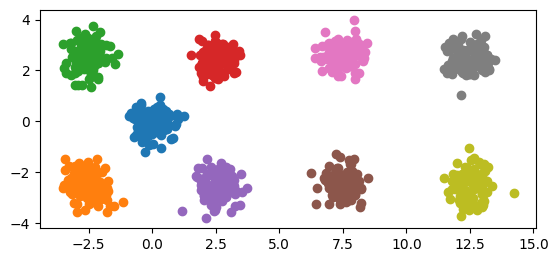

In [21]:
import collections
import itertools
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def plot(df_or_seq):
    if isinstance(df_or_seq, pd.DataFrame):
        seq = map(lambda x: x[1].values, df_or_seq.groupby("label"))
    else:
        seq = df_or_seq
    plt.gca().set_aspect("equal")
    for X in seq:
        plt.scatter(X[:, 0], X[:, 1])


def as_df(results, labels: Iterable[str] = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    """Collects sequence of X into a labeled pd.DataFrame"""
    dfs = []
    for label, result in zip(labels, results):
        if isinstance(result, tuple):
            label, X = result
        else:
            X = result

        dfs.append(pd.DataFrame(dict(x=X[:, 0], y=X[:, 1], label=label)))

    df = pd.concat(dfs)
    df.label = df.label.astype("category")
    return df


Covariance2D = tuple[tuple[float, float], tuple[float, float]]

def base(
    neighborhood_offset: float = 10,
    x: float = 2.5,
    cov: Covariance2D = ((0.2, 0), (0, 0.2)),
    size: int = 100,
):
    corners = (
        (-x, -x),
        (-x, x),
        (x, x),
        (x, -x),
    )
    for mean in (
        (0, 0),
        (-x, -x),
        (-x, x),
        (x, x),
        (x, -x),
        (neighborhood_offset - x, -x),
        (neighborhood_offset - x, x),
        (neighborhood_offset + x, x),
        (neighborhood_offset + x, -x),
    ):
        yield np.random.multivariate_normal(mean, cov, size)


data = list(base())

plot(data)

### Case 1: Displacement

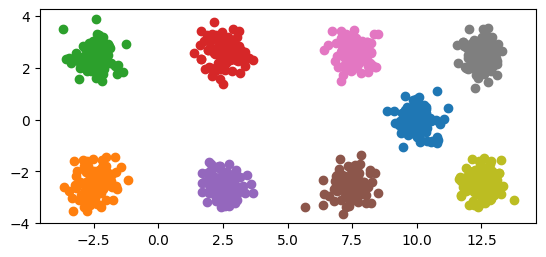

In [8]:
displaced_origin = [data[0] + [10, 0], *data[1:]]

plot(displaced_origin)

### Case 2: Local rotation

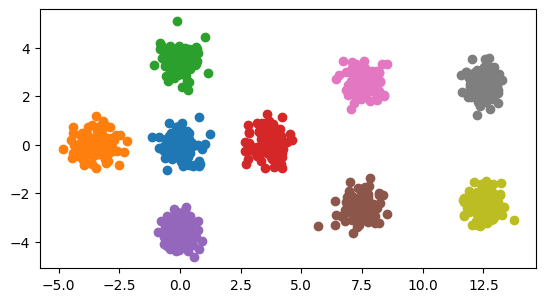

In [9]:
def rotate(x: float):
    theta = np.radians(x)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    return lambda X: X @ R.T


local_rotation = [data[0], *map(rotate(-45), data[1:5]), *data[5:]]

plot(local_rotation)

### Case 3: Global rotation

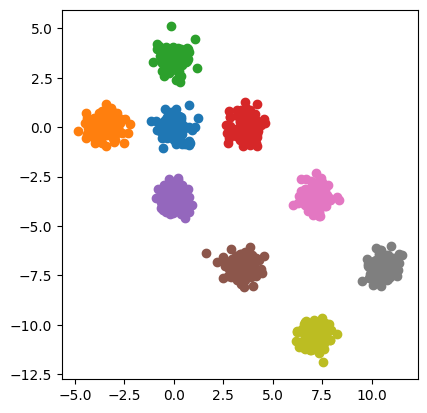

In [10]:
global_rotation = [data[0], *map(rotate(-45), data[1:])]

plot(global_rotation)